<a href="https://colab.research.google.com/github/michaelkhan3/tensorflow_cert_checklist/blob/time-series/01-build-and-train-models/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series

This example will target most of the time series topics on the checklist.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

## Get Data

In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv


--2020-09-07 13:46:05--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2020-09-07 13:46:05 (4.06 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



## Read CSV data

In [3]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)


## Plot data

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

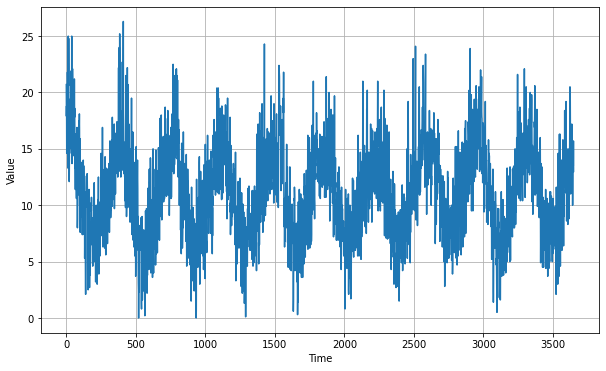

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

## Split training and validation data

We will take the first 2500 data points to train and use the remaining data for validating the model

In [6]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

Set hyperparameter values

In [7]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

## Pre-process data

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [9]:
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


### Create and train model

In [10]:
model = keras.models.Sequential([
                                 keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
                                 keras.layers.LSTM(64, return_sequences=True),
                                 keras.layers.LSTM(64, return_sequences=True),
                                 keras.layers.Dense(30, activation="relu"),
                                 keras.layers.Dense(10, activation="relu"),
                                 keras.layers.Dense(1),
                                 keras.layers.Lambda(lambda x: x * 400)
])

In [11]:
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

In [12]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 0s 28ms/step - loss: 31.1571 - mae: 31.6550
Epoch 2/100
10/10 [==============================] - 0s 23ms/step - loss: 30.5778 - mae: 31.0756
Epoch 3/100
10/10 [==============================] - 0s 24ms/step - loss: 29.6825 - mae: 30.1801
Epoch 4/100
10/10 [==============================] - 0s 23ms/step - loss: 28.5613 - mae: 29.0586
Epoch 5/100
10/10 [==============================] - 0s 25ms/step - loss: 27.1974 - mae: 27.6945
Epoch 6/100
10/10 [==============================] - 0s 24ms/step - loss: 25.5017 - mae: 25.9986
Epoch 7/100
10/10 [==============================] - 0s 35ms/step - loss: 23.3464 - mae: 23.8429
Epoch 8/100
10/10 [==============================] - 0s 35ms/step - loss: 20.6148 - mae: 21.1108
Epoch 9/100
10/10 [==============================] - 0s 31ms/step - loss: 17.3142 - mae: 17.8091
Epoch 10/100
10/10 [==============================] - 0s 25ms/step - loss: 13.6449 - mae: 14.1371
Epoch 11/100
10/10 [=========

## Pick optimal learning rate

(1e-08, 0.0001, 0.0, 60.0)

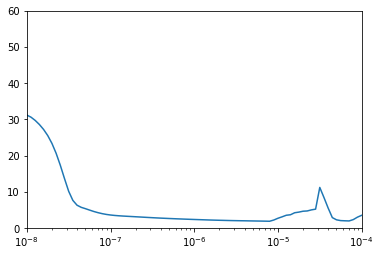

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

Clear keras session so model doesn't continue to learn from where we left off

In [17]:
tf.keras.backend.clear_session()

In [18]:
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = keras.models.Sequential([
                                 keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
                                 keras.layers.LSTM(64, return_sequences=True),
                                 keras.layers.LSTM(64, return_sequences=True),
                                 keras.layers.Dense(30, activation="relu"),
                                 keras.layers.Dense(10, activation="relu"),
                                 keras.layers.Dense(1),
                                 keras.layers.Lambda(lambda x: x * 400)
])

optimizer = keras.optimizers.SGD(learning_rate=6e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

In [19]:
history = model.fit(train_set, epochs=150)

Epoch 1/150
10/10 [==============================] - 0s 21ms/step - loss: 16.6876 - mae: 17.1822
Epoch 2/150
10/10 [==============================] - 0s 23ms/step - loss: 7.2968 - mae: 7.7851
Epoch 3/150
10/10 [==============================] - 0s 24ms/step - loss: 4.1523 - mae: 4.6297
Epoch 4/150
10/10 [==============================] - 0s 23ms/step - loss: 3.2105 - mae: 3.6825
Epoch 5/150
10/10 [==============================] - 0s 33ms/step - loss: 2.5477 - mae: 3.0114
Epoch 6/150
10/10 [==============================] - 0s 24ms/step - loss: 2.1874 - mae: 2.6453
Epoch 7/150
10/10 [==============================] - 0s 24ms/step - loss: 2.0246 - mae: 2.4791
Epoch 8/150
10/10 [==============================] - 0s 23ms/step - loss: 1.9474 - mae: 2.4008
Epoch 9/150
10/10 [==============================] - 0s 33ms/step - loss: 1.9141 - mae: 2.3670
Epoch 10/150
10/10 [==============================] - 0s 32ms/step - loss: 1.8919 - mae: 2.3449
Epoch 11/150
10/10 [===========================

## Create function to get predictions from model

In [20]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [21]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

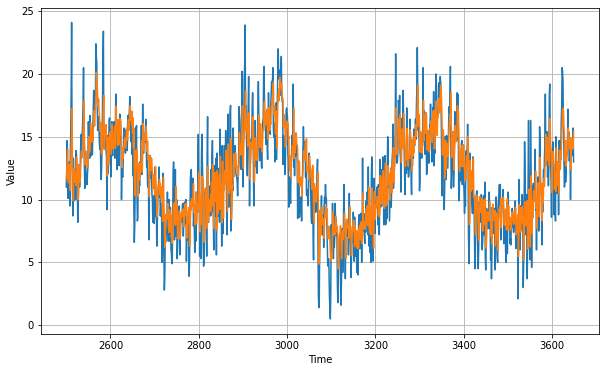

In [22]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.8342323